# 参考mnist_conv-keras实现针对cifar10的alexNet卷积模型


#### 链接: https://pan.baidu.com/s/1LcCPcK9DgLS3W_DUPZS8kQ 提取码: 5vwz
### 解压放到 ~/.keras/datasets/

## tar zxvf cifar***.tar.zip

## 准备数据

In [17]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

def cifar10_dataset():
    (x, y), (x_test, y_test) = datasets.cifar10.load_data()
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(prepare_mnist_features_and_labels)
    ds = ds.take(20000).shuffle(20000).batch(100)
    
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    test_ds = test_ds.map(prepare_mnist_features_and_labels)
    test_ds = test_ds.take(20000).batch(20000)
    return ds, test_ds

def prepare_mnist_features_and_labels(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.int64)
    return x, y

## 建立模型

In [18]:
class myConvModel(keras.Model):
    '''在这里实现alexNet模型'''
    def __init__(self):
        super(myConvModel, self).__init__()
        self.l1_conv = Conv2D(filters=32, 
                              kernel_size=(5, 5), 
                              activation='relu', padding='same')
        
        self.l2_conv = Conv2D(filters=64, 
                              kernel_size=(5, 5), 
                              activation='relu',padding='same')
        
        self.pool = MaxPooling2D(pool_size=(2, 2), strides=2)
        
        self.flat = Flatten()
        self.dense1 = layers.Dense(100, activation='tanh')
        self.dense2 = layers.Dense(10)
    @tf.function
    def call(self, x):
        h1 = self.l1_conv(x) 
        h1_pool = self.pool(h1) 
        h2 = self.l2_conv(h1_pool)
        h2_pool = self.pool(h2) 
        flat_h = self.flat(h2_pool)
        dense1 = self.dense1(flat_h)
        logits = self.dense2(dense1)
        probs = tf.nn.softmax(logits, axis=-1)
        return probs
    
    @tf.function
    def getL1_feature_map(self, x):
        h1 = self.l1_conv(x) # [32, 28, 28, 32]
        
        return h1
    
    @tf.function
    def getL2_feature_map(self, x):
        h1 = self.l1_conv(x) # [32, 28, 28, 32]
        h1_pool = self.pool(h1) # [32, 14, 14, 32]
        h2 = self.l2_conv(h1_pool) #[32, 14, 14, 64]
        return h2

model = myConvModel()
optimizer = optimizers.Adam(0.001)

## 编译， fit以及evaluate

In [19]:
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
train_ds, test_ds = cifar10_dataset()
model.fit(train_ds, epochs=10)
model.evaluate(test_ds)

Epoch 1/10
200/200 [==============================] - 39s 194ms/step - loss: 1.7324 - accuracy: 0.2804
Epoch 2/10
200/200 [==============================] - 39s 195ms/step - loss: 1.3322 - accuracy: 0.5093
Epoch 3/10
200/200 [==============================] - 35s 173ms/step - loss: 1.1601 - accuracy: 0.5723
Epoch 4/10
200/200 [==============================] - 34s 171ms/step - loss: 1.0495 - accuracy: 0.6118
Epoch 5/10
200/200 [==============================] - 34s 172ms/step - loss: 0.9545 - accuracy: 0.6571
Epoch 6/10
200/200 [==============================] - 34s 172ms/step - loss: 0.8730 - accuracy: 0.6848
Epoch 7/10
200/200 [==============================] - 35s 174ms/step - loss: 0.8043 - accuracy: 0.7066
Epoch 8/10
200/200 [==============================] - 34s 171ms/step - loss: 0.7410 - accuracy: 0.7300
Epoch 9/10
200/200 [==============================] - 34s 172ms/step - loss: 0.6887 - accuracy: 0.7506
Epoch 10/10
1/1 [==============================] - 8s 8s/step - loss: 1.2

[1.2258973121643066, 0.6064]

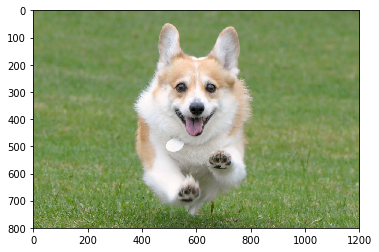

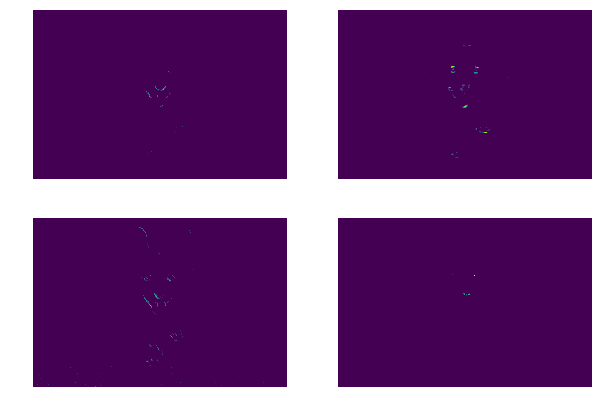

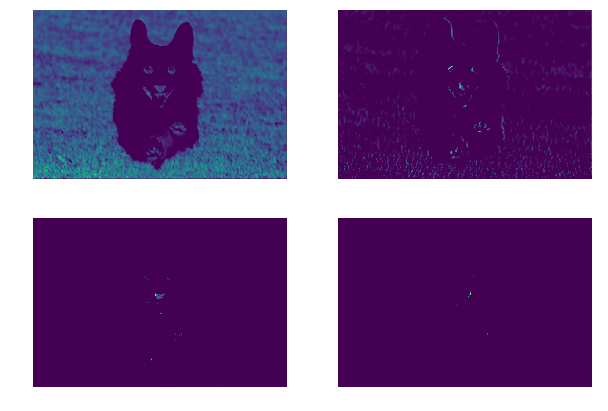

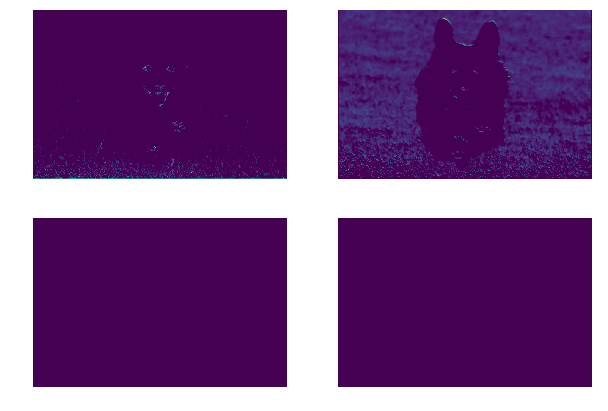

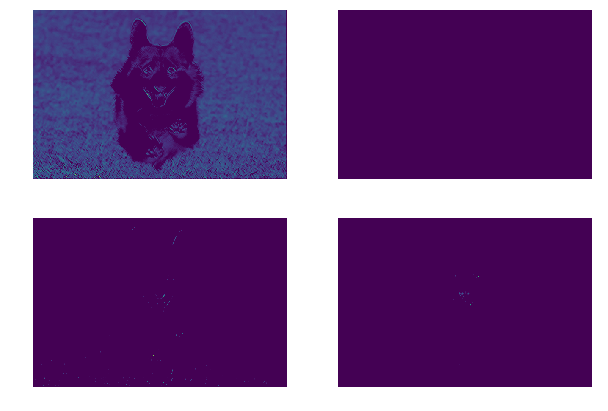

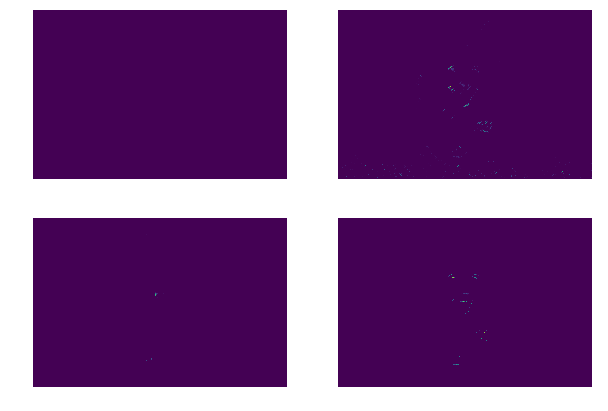

In [20]:
import numpy
import pylab
from PIL import Image
import numpy as np

ds, test_ds = cifar10_dataset()

for i in test_ds:
    test_batch = i[0][:1, :, :]
    break
img = Image.open(open('corgi.jpg', 'rb'))
img = numpy.asarray(img, dtype='float32') / 256.
# print(img.shape)
img = np.expand_dims(img, axis=0)

# img = test_batch
img_out = model.getL2_feature_map(img)
pylab.imshow(img[0, :, :, :])

pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 0])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 1])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 2])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 3])
pylab.show()

pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 4])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 5])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 6])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 7])
pylab.show()

pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 8])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 9])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 10])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 11])
pylab.show()

pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 12])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 13])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 14])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 15])
pylab.show()


pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 16])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 17])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 18])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 19])
pylab.show()



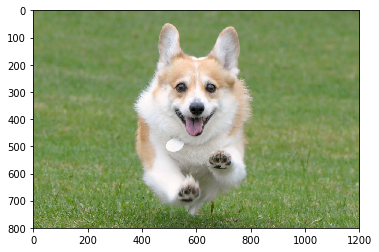

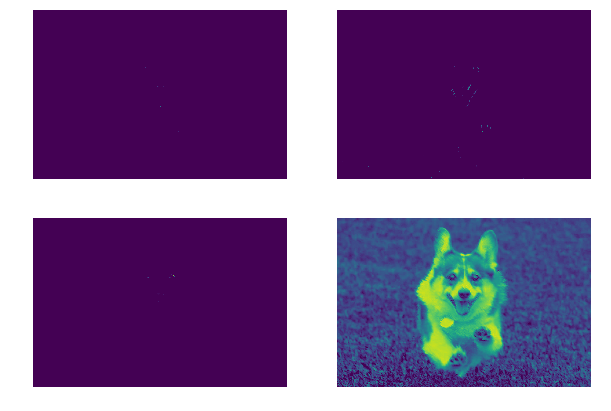

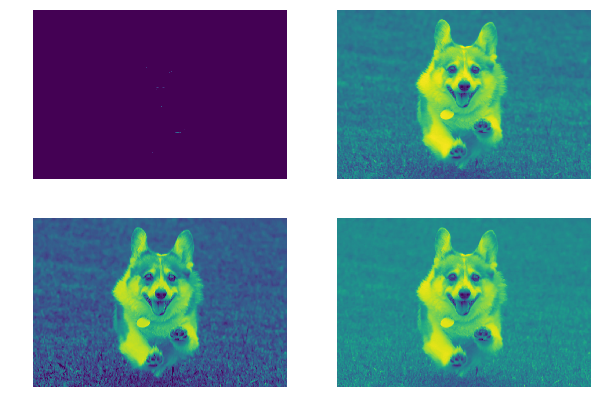

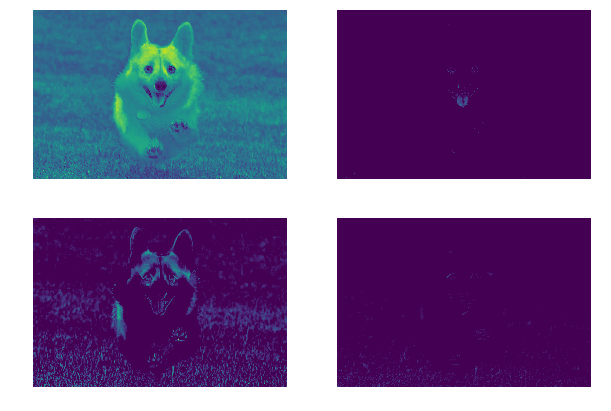

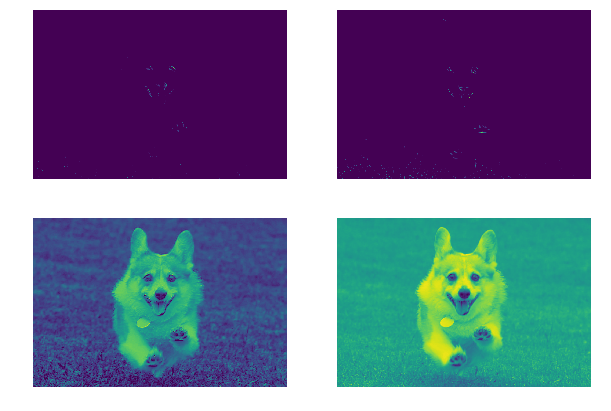

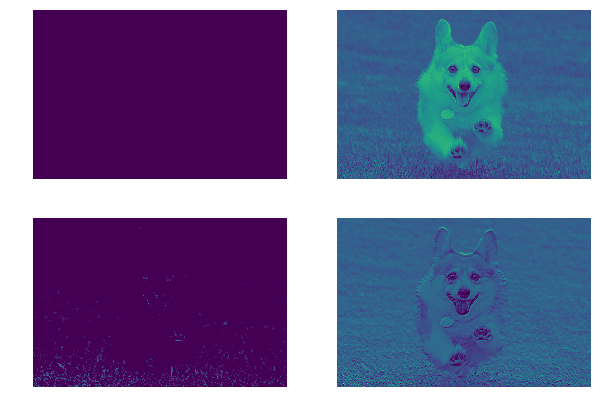

In [23]:
import numpy
import pylab
from PIL import Image
import numpy as np
rand_model = myConvModel()
ds, test_ds = cifar10_dataset()

for i in test_ds:
    test_batch = i[0][:1, :, :]
    break
img = Image.open(open('corgi.jpg', 'rb'))
img = numpy.asarray(img, dtype='float32') / 256.
# print(img.shape)
img = np.expand_dims(img, axis=0)

# img = test_batch
img_out = rand_model.getL1_feature_map(img)
pylab.imshow(img[0, :, :, :])

pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 0])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 1])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 2])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 3])
pylab.show()

pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 4])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 5])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 6])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 7])
pylab.show()

pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 8])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 9])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 10])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 11])
pylab.show()

pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 12])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 13])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 14])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 15])
pylab.show()


pylab.figure(figsize=(10,7))
pylab.subplot(2, 2, 1); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 16])
pylab.subplot(2, 2, 2); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 17])
pylab.subplot(2, 2, 3); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 18])
pylab.subplot(2, 2, 4); pylab.axis('off'); pylab.imshow(img_out[0, :, :, 19])
pylab.show()

